# Spatial Features, OLS Regression, and XGBoost with SHAP Analysis

This notebook performs a comprehensive analysis of quality of life (QOL) call rates in NYC using:
1. Spatial feature engineering (network analysis, POI density, KNN distances).
2. OLS regression with cross-validation.
3. Variance Inflation Factor (VIF) calculation.
4. Correlation matrix analysis.
5. XGBoost regression with SHAP interpretability.
6. Detailed statistical model outputs using statsmodels.

## 1. Import Required Libraries

In [1]:
# Import standard libraries for data manipulation and mathematical operations.
import math
import pandas as pd
import geopandas as gpd
import numpy as np

# Import spatial analysis and network libraries.
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import libpysal as ps

# Import machine learning and statistical modeling libraries.
from sklearn.model_selection import KFold, cross_val_score, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import BallTree
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import xgboost as xgb

# Import spatial autocorrelation and error model libraries.
from esda.moran import Moran
from spreg import GM_Error

# Import visualization and interpretability libraries.
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Import utility libraries.
from tqdm import tqdm
import warnings

# Suppress warnings for cleaner output.
warnings.filterwarnings("ignore")

## 2. Load Data and Prepare Base Datasets

In [2]:
# Define file paths for all required datasets.
weekly_path = "data/model/nyc_tract_summer_2025_weekly.csv"
tracts_path = "data/nyc_tracts_2020/nyc_tracts_2020.shp"
nyc_boundary_path = "data/nyc_city_boundary_with_water/nyc_city_boundary_with_water.shp"

# Load the panel dataset containing weekly quality of life call data and predictor variables.
panel = pd.read_csv(weekly_path)

# Display the columns in the panel dataset to understand available variables.
print("Panel Dataset Columns:")
print(panel.columns.tolist())

Panel Dataset Columns:
['GEOID', 'WEEK', 'TOTAL_CALLS_WEEK', 'QOL_CALLS_WEEK', 'EXTREME_DAYS_WEEK', 'MEDIAN_TMAX_F', 'EXTREME_WEEK_1', 'EXTREME_WEEK_2', 'TOTAL_POP', 'MEDIAN_INCOME', 'NO_VEHICLE_HH', 'HH_TOTAL', 'POP_DENSITY', 'POVERTY_RATE', 'PCT_BACHELORS_PLUS', 'PCT_RENTERS', 'PCT_LIMITED_ENGLISH', 'PCT_TREE_CANOPY', 'PCT_IMPERVIOUS', 'MEAN_LANDCOVER', 'BD', 'AH', 'NDVI', 'WCR', 'QOL_RATE_1K', 'QOL_RATE_10K', 'LOG_QOL_RATE_1K', 'LOG_QOL_RATE_10K']


In [3]:
# Convert GEOID to string type to ensure consistent merging across datasets.
panel["GEOID"] = panel["GEOID"].astype(str)

# Define the dependent variable for our regression analysis.
y_col = "QOL_RATE_1K"

# Remove any rows where the dependent variable is missing to ensure clean data.
panel = panel.dropna(subset=[y_col])

print(f"\nPanel dataset shape after removing missing {y_col}: {panel.shape}")


Panel dataset shape after removing missing QOL_RATE_1K: (29485, 28)


In [4]:
# Load the census tract geometries as a GeoDataFrame.
tracts = gpd.read_file(tracts_path)

# Convert GEOID to string type for consistent merging.
tracts["geoid"] = tracts["geoid"].astype(str)

# Reproject to NAD83 / New York Long Island (ftUS) for accurate distance calculations in feet.
tracts = tracts.to_crs("EPSG:32118")

# Calculate the centroid of each tract for spatial analysis.
tracts["centroid"] = tracts.centroid

# Extract x and y coordinates from the centroid for use in spatial calculations.
tracts["x"] = tracts.centroid.x
tracts["y"] = tracts.centroid.y

print(f"\nLoaded {len(tracts)} census tracts with geometries.")


Loaded 2325 census tracts with geometries.


## 3. Spatial Feature Engineering

### 3.1 Street Network Analysis

In [5]:
# Download the walkable street network for New York City using OSMnx.
# This network will be used to calculate network-based accessibility metrics.
print("Downloading street network from OpenStreetMap...")
G = ox.graph_from_place("New York City, New York, USA", network_type="walk")

# Project the graph to the same coordinate reference system as our tracts.
G = ox.project_graph(G)

print(f"Street network loaded with {len(G.nodes)} nodes and {len(G.edges)} edges.")

Street network loaded with 268220 nodes and 862882 edges.


In [6]:
# Assign each tract centroid to the nearest node in the street network.
# This allows us to calculate network distances from each tract.
print("\nAssigning tract centroids to nearest network nodes...")
tracts["nn"] = ox.nearest_nodes(G, tracts["x"], tracts["y"])

print("Nearest node assignment complete.")


Assigning tract centroids to nearest network nodes...
Nearest node assignment complete.


### 3.2 Point of Interest (POI) Density Calculation

In [7]:
# Download Points of Interest (POIs) from OpenStreetMap for New York City.
# POIs include amenities like restaurants, shops, parks, and other urban features.
print("\nDownloading Points of Interest from OpenStreetMap...")

# Define the tags for POI features we want to download.
tags = {
    "amenity": [
        "library",
        "community_centre", 
        "social_facility",
        "bus_station",
        "bar",
        "restaurant",
        "fast_food",
        "toilets",
        "hospital",
        "clinic",
        "pharmacy"
    ],
    "shop": [
        "convenience",
        "supermarket",
        "alcohol",
        "deli"
    ],
    "leisure": ["park"],
    "public_transport": ["station"]
}

# Download POIs as points for New York City.
pois = ox.features_from_place(
    "New York City, New York, USA", 
    tags=tags
)

# Filter to only include point geometries for easier density calculations.
pois = pois[pois.geometry.type == "Point"]

# Project POIs to match the coordinate reference system of our tracts.
pois = pois.to_crs("EPSG:32118")

print(f"Downloaded {len(pois)} POI points.")


Downloaded 21309 POI points.


In [8]:
# Calculate POI density within a buffer around each tract centroid.
# This provides a measure of urban amenity accessibility for each tract.
print("\nCalculating POI density within 500m buffer of each tract centroid...")

# Define the buffer distance in feet (500 meters ≈ 1640 feet).
buffer_distance = 1640

# Initialize an empty list to store POI counts.
poi_counts = []

# Iterate through each tract to count POIs within the buffer.
for idx, row in tqdm(tracts.iterrows(), total=len(tracts), desc="Calculating POI density"):
    # Create a circular buffer around the tract centroid.
    buffer = row["centroid"].buffer(buffer_distance)
    
    # Count the number of POIs that fall within this buffer.
    poi_count = pois[pois.within(buffer)].shape[0]
    
    poi_counts.append(poi_count)

# Add the POI density counts to the tracts GeoDataFrame.
tracts["POI_500M_DENSITY"] = poi_counts

print(f"POI density calculation complete. Mean POI count: {tracts['POI_500M_DENSITY'].mean():.2f} per tract.")


Calculating POI density within 500m buffer of each tract centroid...


Calculating POI density: 100%|██████████| 2325/2325 [00:23<00:00, 98.79it/s] 

POI density calculation complete. Mean POI count: 324.39 per tract.


### 3.3 K-Nearest Neighbor Distance Calculations

In [14]:
# Download subway station locations from OpenStreetMap.
# Subway access is an important urban amenity that can affect quality of life.
print("\nDownloading subway station locations...")

# Define the tags to identify subway stations in OSM data.
subway_tags = {"railway": "station", "station": "subway"}

# Download subway stations as points.
subway_stations = ox.features_from_place(
    "New York City, New York, USA", 
    tags=subway_tags
)

# Filter to only include point geometries.
subway_stations = subway_stations[subway_stations.geometry.type == "Point"]

# Project to match our tract CRS.
subway_stations = subway_stations.to_crs("EPSG:32118")

print(f"Downloaded {len(subway_stations)} subway station locations.")


Downloaded 550 subway station locations.


In [15]:
# Calculate the mean distance to the K nearest subway stations for each tract.
# This provides a measure of transit accessibility.
print("\nCalculating K-Nearest Neighbor distances to subway stations...")

# Define the number of nearest neighbors to consider.
k = 5

# Extract coordinates from subway stations.
subway_coords = np.array([[point.x, point.y] for point in subway_stations.geometry])

# Extract coordinates from tract centroids.
tract_coords = np.array([[row["x"], row["y"]] for idx, row in tracts.iterrows()])

# Build a BallTree for efficient nearest neighbor queries.
# BallTree is optimized for spatial queries in multiple dimensions.
tree = BallTree(subway_coords, metric="euclidean")

# Query the tree to find distances to the k nearest subway stations.
distances, indices = tree.query(tract_coords, k=k)

# Calculate the mean distance to the k nearest stations for each tract.
tracts["KNN_SUBWAY_dist_mean"] = distances.mean(axis=1)

print(f"KNN distance calculation complete. Mean distance to {k} nearest subway stations: {tracts['KNN_SUBWAY_dist_mean'].mean():.2f} feet.")


Calculating K-Nearest Neighbor distances to subway stations...
KNN distance calculation complete. Mean distance to 5 nearest subway stations: 1278.57 feet.


### 3.4 Merge Spatial Features with Panel Data

In [16]:
# Select only the spatial features we calculated plus the GEOID for merging.
spatial_features = tracts[["geoid", "POI_500M_DENSITY", "KNN_SUBWAY_dist_mean"]].copy()

# Rename the geoid column to match the panel dataset.
spatial_features = spatial_features.rename(columns={"geoid": "GEOID"})

# Merge the spatial features with the panel dataset.
# This adds our calculated spatial features to each tract-week observation.
panel = panel.merge(spatial_features, on="GEOID", how="left")

print(f"\nSpatial features merged. Panel dataset now has {panel.shape[1]} columns.")
print(f"Number of missing values in spatial features:")
print(panel[["POI_500M_DENSITY", "KNN_SUBWAY_dist_mean"]].isnull().sum())


Spatial features merged. Panel dataset now has 34 columns.
Number of missing values in spatial features:
POI_500M_DENSITY        0
KNN_SUBWAY_dist_mean    0
dtype: int64


## 4. Model Preparation and Train-Test Split

In [17]:
# Define different sets of predictor variables for model comparison.
# This allows us to test different model specifications.

# Socioeconomic and demographic predictors.
acs_predictors = [
    "PCT_BACHELORS_PLUS",
    "PCT_RENTERS",
    "PCT_LIMITED_ENGLISH",
    "MEDIAN_INCOME"
]

# Environmental predictors.
env_predictors = [
    "PCT_TREE_CANOPY",
    "PCT_IMPERVIOUS",
    "WCR",
    "NDVI"
]

# Urban form predictors.
# Parks were HIGHLY correlated to subway.
urban_predictors = [
    "BD",   # Building density.
    "AH",   # Average building height.
    "POI_500M_DENSITY",
    "KNN_SUBWAY_dist_mean"
]

# Combined predictor set with all features.
all_predictors = env_predictors + acs_predictors + urban_predictors

print(f"\nDefined predictor sets:")
print(f"- Base predictors: {len(env_predictors)}")
print(f"- Spatial predictors: {len(acs_predictors)}")
print(f"- Building predictors: {len(urban_predictors)}")
print(f"- All predictors: {len(all_predictors)}")


Defined predictor sets:
- Base predictors: 4
- Spatial predictors: 4
- Building predictors: 4
- All predictors: 12


In [18]:
# Create different data regimes for separate regression analyses.
# This allows us to compare model performance across different time periods or data subsets.

# Define temporal regimes based on extreme heat weeks.
# EXTREME_WEEK_1 and EXTREME_WEEK_2 are binary indicators of extreme heat events.

# Full dataset regime.
#df_full = panel.copy()

# Extreme week 1 only (first extreme heat period).
df_extreme1 = panel[panel["EXTREME_WEEK_1"] == 1].copy()

# Extreme week 2 only (second extreme heat period).
df_extreme2 = panel[panel["EXTREME_WEEK_2"] == 1].copy()

# Non-extreme weeks only (baseline periods).
df_nonextreme1 = panel[(panel["EXTREME_WEEK_1"] == 0)].copy()

# Non-extreme weeks only (baseline periods).
df_nonextreme2 = panel[(panel["EXTREME_WEEK_2"] == 0)].copy()

# Non-extreme weeks only (baseline periods).
#df_nonextreme = panel[(panel["EXTREME_WEEK_1"] == 0) & (panel["EXTREME_WEEK_2"] == 0)].copy()

# Store regimes in a dictionary for easy iteration.
regimes = {
    #"Full Data": df_full,
    "Extreme Week 1": df_extreme1,
    "Extreme Week 2": df_extreme2,
    "Non-Extreme Week 1": df_nonextreme1,
    "Non-Extreme Week 2": df_nonextreme2,
    #"Non-Extreme Weeks": df_nonextreme
}

print(f"\nCreated data regimes:")
for regime_name, regime_df in regimes.items():
    print(f"- {regime_name}: {len(regime_df)} observations")


Created data regimes:
- Extreme Week 1: 15042 observations
- Extreme Week 2: 9876 observations
- Non-Extreme Week 1: 14443 observations
- Non-Extreme Week 2: 19609 observations


In [19]:
# Create a dictionary of predictor sets for systematic model comparison.
predictor_sets = {
    "Environmental Only": env_predictors,
    "Environmental + ACS": env_predictors + acs_predictors,
    "Environmental + Urban": env_predictors + urban_predictors,
    "All Features": all_predictors
}

print(f"\nPredictor sets defined for model comparison:")
for set_name, predictors in predictor_sets.items():
    print(f"- {set_name}: {len(predictors)} predictors")


Predictor sets defined for model comparison:
- Environmental Only: 4 predictors
- Environmental + ACS: 8 predictors
- Environmental + Urban: 8 predictors
- All Features: 12 predictors


## 5. OLS Regression with Cross-Validation

In [20]:
# Perform OLS regression with GroupKFold cross-validation across all regimes and predictor sets.
# GroupKFold ensures that all observations from the same census tract stay in the same fold.
# This prevents data leakage and provides more realistic performance estimates.

print("\n" + "="*80)
print("RUNNING OLS REGRESSION WITH CROSS-VALIDATION")
print("="*80)

# Initialize variables to track the best model.
best_r2 = -np.inf
best_model_data = None

# Store all results for comparison.
results_list = []

# Iterate through each regime (time period).
for regime_name, df_regime in regimes.items():
    print(f"\n{'='*80}")
    print(f"REGIME: {regime_name}")
    print(f"{'='*80}")
    print(f"Sample size: {len(df_regime)} observations")
    
    # Iterate through each predictor set.
    for set_name, predictors in predictor_sets.items():
        print(f"\n  Predictor Set: {set_name}")
        print(f"  {'-'*76}")
        
        # Check if all predictors are available in this regime.
        available_predictors = [p for p in predictors if p in df_regime.columns]
        
        if len(available_predictors) != len(predictors):
            missing = set(predictors) - set(available_predictors)
            print(f"  Warning: Missing predictors {missing}. Skipping this set.")
            continue
        
        # Prepare feature matrix (X) and target vector (y).
        # Drop any rows with missing values in either predictors or outcome.
        df_clean = df_regime.dropna(subset=available_predictors + [y_col])
        
        if len(df_clean) < 100:
            print(f"  Warning: Insufficient data after cleaning ({len(df_clean)} rows). Skipping.")
            continue
        
        X = df_clean[available_predictors].astype(float)
        y = df_clean[y_col].astype(float)
        groups = df_clean["GEOID"]
        
        # Initialize GroupKFold cross-validator with 10 folds.
        # This ensures each census tract appears in only one fold.
        gkf = GroupKFold(n_splits=10)
        
        # Initialize the OLS linear regression model.
        ols_model = LinearRegression()
        
        # Perform cross-validation and calculate R-squared scores.
        # R-squared measures the proportion of variance explained by the model.
        cv_scores = cross_val_score(
            ols_model, 
            X, 
            y, 
            groups=groups, 
            scoring="r2", 
            cv=gkf
        )
        
        # Calculate mean and standard deviation of cross-validation scores.
        mean_r2 = cv_scores.mean()
        std_r2 = cv_scores.std()
        
        print(f"  Predictors: {', '.join(available_predictors)}")
        print(f"  CV R-squared (Mean ± Std): {mean_r2:.4f} ± {std_r2:.4f}")
        
        # Store results for this model.
        results_list.append({
            "regime": regime_name,
            "set_name": set_name,
            "mean_r2": mean_r2,
            "std_r2": std_r2,
            "n_predictors": len(available_predictors),
            "n_obs": len(df_clean)
        })
        
        # Update best model if this one performs better.
        if mean_r2 > best_r2:
            best_r2 = mean_r2
            best_model_data = {
                "regime": regime_name,
                "set_name": set_name,
                "predictors": available_predictors,
                "df": df_clean,
                "mean_r2": mean_r2,
                "std_r2": std_r2
            }

# Print summary of best model.
print(f"\n\n{'='*80}")
print("BEST MODEL SUMMARY")
print(f"{'='*80}")
if best_model_data:
    print(f"Regime: {best_model_data['regime']}")
    print(f"Predictor Set: {best_model_data['set_name']}")
    print(f"CV R-squared: {best_model_data['mean_r2']:.4f} ± {best_model_data['std_r2']:.4f}")
    print(f"Number of Predictors: {len(best_model_data['predictors'])}")
    print(f"Number of Observations: {len(best_model_data['df'])}")
else:
    print("No valid model was found.")


RUNNING OLS REGRESSION WITH CROSS-VALIDATION

REGIME: Extreme Week 1
Sample size: 15042 observations

  Predictor Set: Environmental Only
  ----------------------------------------------------------------------------
  Predictors: PCT_TREE_CANOPY, PCT_IMPERVIOUS, WCR, NDVI
  CV R-squared (Mean ± Std): 0.0030 ± 0.0085

  Predictor Set: Environmental + ACS
  ----------------------------------------------------------------------------
  Predictors: PCT_TREE_CANOPY, PCT_IMPERVIOUS, WCR, NDVI, PCT_BACHELORS_PLUS, PCT_RENTERS, PCT_LIMITED_ENGLISH, MEDIAN_INCOME
  CV R-squared (Mean ± Std): 0.0272 ± 0.0143

  Predictor Set: Environmental + Urban
  ----------------------------------------------------------------------------
  Predictors: PCT_TREE_CANOPY, PCT_IMPERVIOUS, WCR, NDVI, BD, AH, POI_500M_DENSITY, KNN_SUBWAY_dist_mean
  CV R-squared (Mean ± Std): 0.0247 ± 0.0128

  Predictor Set: All Features
  ----------------------------------------------------------------------------
  Predictors:

In [21]:
# Create a results DataFrame for easy comparison of all models.
results_df = pd.DataFrame(results_list)

# Sort by mean R-squared in descending order.
results_df = results_df.sort_values("mean_r2", ascending=False)

print("\nAll Model Results (sorted by R-squared):")
print(results_df.to_string(index=False))


All Model Results (sorted by R-squared):
            regime              set_name  mean_r2   std_r2  n_predictors  n_obs
    Extreme Week 2          All Features 0.058834 0.022937            12   9699
    Extreme Week 1          All Features 0.054221 0.014705            12  14658
Non-Extreme Week 2          All Features 0.037358 0.014276            12  18859
Non-Extreme Week 1          All Features 0.033684 0.009297            12  13900
    Extreme Week 2   Environmental + ACS 0.032416 0.022462             8   9699
    Extreme Week 1   Environmental + ACS 0.027167 0.014329             8  14658
    Extreme Week 1 Environmental + Urban 0.024726 0.012778             8  15042
    Extreme Week 2 Environmental + Urban 0.024017 0.018483             8   9876
Non-Extreme Week 2 Environmental + Urban 0.020916 0.008089             8  19606
Non-Extreme Week 1 Environmental + Urban 0.018911 0.010368             8  14440
Non-Extreme Week 2   Environmental + ACS 0.018078 0.012739             8  1885

## 6. Variance Inflation Factor (VIF) Calculation

In [22]:
# Calculate Variance Inflation Factor (VIF) for the best model.
# VIF measures multicollinearity among predictor variables.
# High VIF (>10) indicates problematic multicollinearity.

if best_model_data:
    print(f"\n{'='*80}")
    print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
    print(f"{'='*80}\n")
    
    # Prepare the feature matrix from the best model.
    X_vif = best_model_data["df"][best_model_data["predictors"]].astype(float)
    
    # Calculate VIF for each predictor variable.
    # VIF_i = 1 / (1 - R²_i), where R²_i is from regressing predictor i on all other predictors.
    vif_data = pd.DataFrame()
    vif_data["Predictor"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    
    # Sort by VIF in descending order to identify most problematic variables.
    vif_data = vif_data.sort_values("VIF", ascending=False)
    
    print("VIF Values for Best Model Predictors:")
    print(vif_data.to_string(index=False))
    print(f"\nInterpretation:")
    print(f"  VIF < 5: Low multicollinearity.")
    print(f"  5 ≤ VIF < 10: Moderate multicollinearity.")
    print(f"  VIF ≥ 10: High multicollinearity (consider removing variable).")
    
    # Identify variables with high VIF.
    high_vif = vif_data[vif_data["VIF"] >= 10]
    if len(high_vif) > 0:
        print(f"\n  Warning: {len(high_vif)} variable(s) with high VIF detected:")
        print(f"  {', '.join(high_vif['Predictor'].tolist())}")
else:
    print("\nNo best model available for VIF calculation.")


VARIANCE INFLATION FACTOR (VIF) ANALYSIS

VIF Values for Best Model Predictors:
           Predictor       VIF
      PCT_IMPERVIOUS 41.350613
                  BD 22.044959
         PCT_RENTERS 13.458565
                NDVI 11.896095
  PCT_BACHELORS_PLUS  8.836547
KNN_SUBWAY_dist_mean  4.936903
                  AH  4.483360
     PCT_TREE_CANOPY  4.397697
    POI_500M_DENSITY  4.038848
 PCT_LIMITED_ENGLISH  1.552766
                 WCR  1.135508
       MEDIAN_INCOME  1.032964

Interpretation:
  VIF < 5: Low multicollinearity.
  5 ≤ VIF < 10: Moderate multicollinearity.
  VIF ≥ 10: High multicollinearity (consider removing variable).

  PCT_IMPERVIOUS, BD, PCT_RENTERS, NDVI


## 7. Correlation Matrix Analysis


CORRELATION MATRIX ANALYSIS



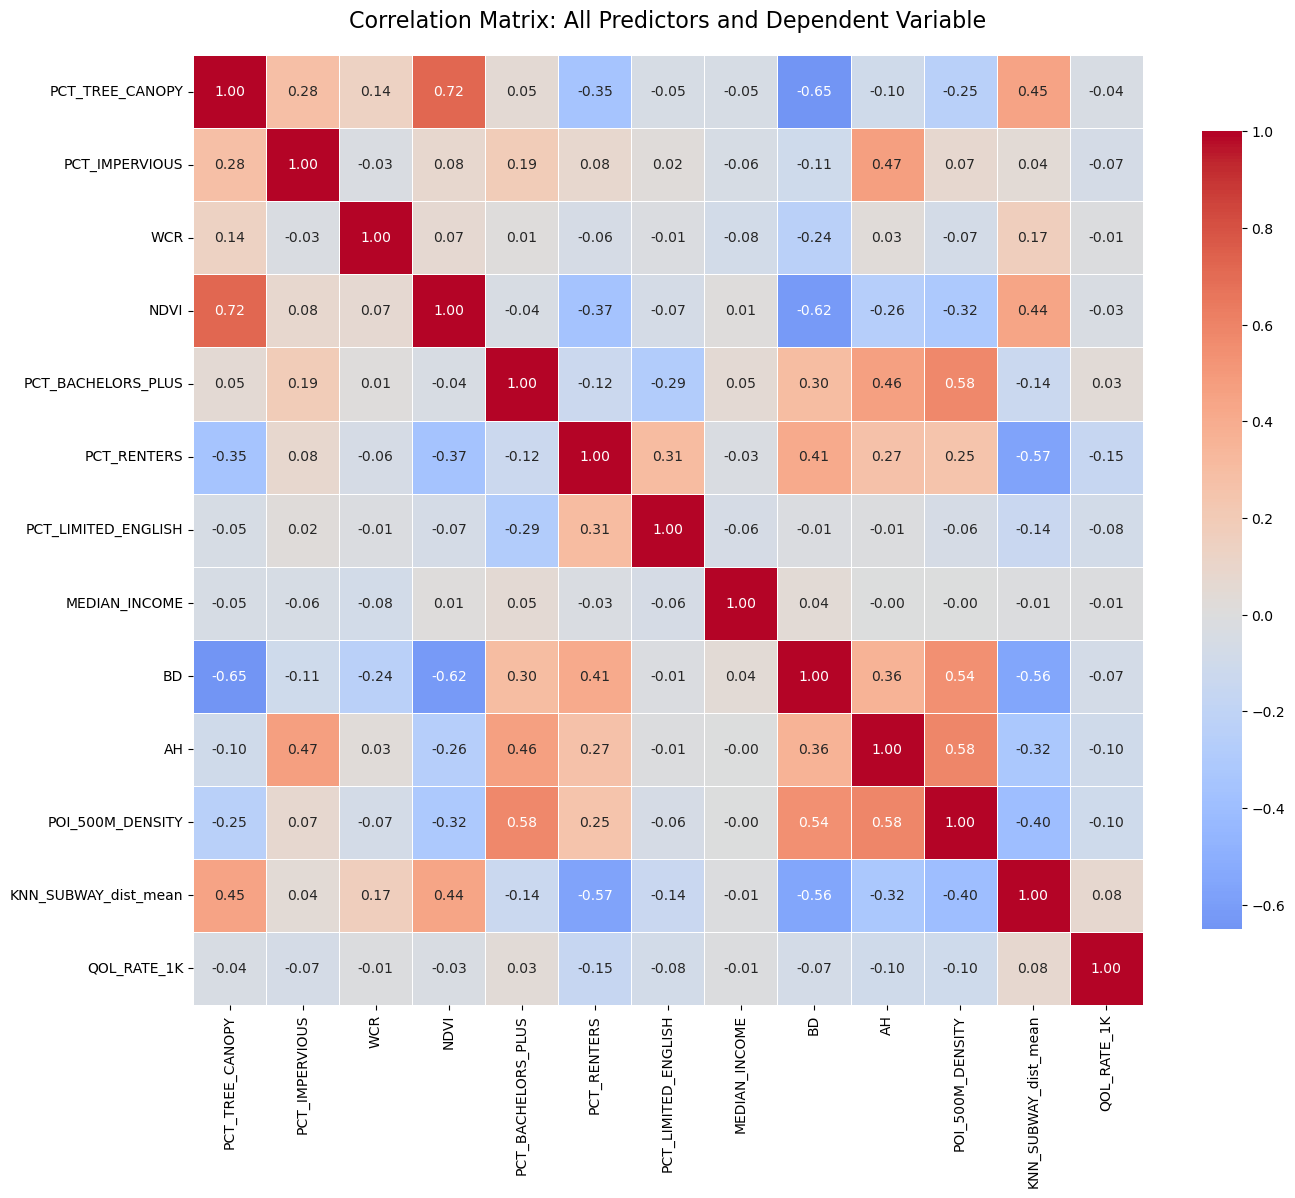


Correlations with Dependent Variable (QOL_RATE_1K):
KNN_SUBWAY_dist_mean    0.077800
PCT_BACHELORS_PLUS      0.034739
MEDIAN_INCOME          -0.005937
WCR                    -0.009357
NDVI                   -0.032543
PCT_TREE_CANOPY        -0.039870
PCT_IMPERVIOUS         -0.066197
BD                     -0.073863
PCT_LIMITED_ENGLISH    -0.081378
AH                     -0.100024
POI_500M_DENSITY       -0.103369
PCT_RENTERS            -0.154182


Strong Predictor-Predictor Correlations (|r| > 0.7):
  PCT_TREE_CANOPY <-> NDVI: 0.721


In [23]:
# Create a correlation matrix of all predictor variables and the dependent variable.
# This helps identify linear relationships between variables.

if best_model_data:
    print(f"\n{'='*80}")
    print("CORRELATION MATRIX ANALYSIS")
    print(f"{'='*80}\n")
    
    # Prepare data for correlation analysis.
    correlation_vars = best_model_data["predictors"] + [y_col]
    correlation_data = best_model_data["df"][correlation_vars].astype(float)
    
    # Calculate Pearson correlation coefficients.
    correlation_matrix = correlation_data.corr()
    
    # Create a heatmap visualization of the correlation matrix.
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Correlation Matrix: All Predictors and Dependent Variable", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Print correlations with the dependent variable.
    print("\nCorrelations with Dependent Variable (QOL_RATE_1K):")
    y_correlations = correlation_matrix[y_col].drop(y_col).sort_values(ascending=False)
    print(y_correlations.to_string())
    
    # Identify strong correlations between predictors.
    print("\n\nStrong Predictor-Predictor Correlations (|r| > 0.7):")
    strong_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                var1 = correlation_matrix.columns[i]
                var2 = correlation_matrix.columns[j]
                corr_val = correlation_matrix.iloc[i, j]
                strong_corr.append(f"  {var1} <-> {var2}: {corr_val:.3f}")
    
    if strong_corr:
        for item in strong_corr:
            print(item)
    else:
        print("  No strong correlations found between predictors.")
else:
    print("\nNo best model available for correlation analysis.")

## 8. XGBoost Regression with SHAP Analysis

In [24]:
# Train an XGBoost model on the best predictor set identified from OLS analysis.
# XGBoost is a gradient boosting algorithm that often provides better predictive performance.

if best_model_data:
    print(f"\n{'='*80}")
    print("XGBOOST REGRESSION MODEL")
    print(f"{'='*80}\n")
    print(f"Training XGBoost on: {best_model_data['regime']} with {best_model_data['set_name']} Predictors")
    print(f"OLS CV R-squared for comparison: {best_model_data['mean_r2']:.4f}\n")
    
    # Prepare feature matrix and target vector.
    X_best = best_model_data["df"][best_model_data["predictors"]].astype(float)
    y_best = best_model_data["df"][y_col].astype(float)
    groups = best_model_data["df"]["GEOID"]
    
    # Initialize XGBoost Regressor with carefully tuned hyperparameters.
    print("Initializing XGBoost Regressor with the following parameters:")
    print("  - Objective: reg:squarederror (for continuous regression).")
    print("  - Number of estimators: 400 (number of boosting rounds).")
    print("  - Max depth: 5 (maximum tree depth to control overfitting).")
    print("  - Learning rate: 0.05 (step size shrinkage to prevent overfitting).")
    print("  - Random state: 42 (for reproducibility).")
    print("  - n_jobs: -1 (use all available CPU cores).\n")
    
    xgb_reg = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    )
    
    # Perform GroupKFold cross-validation to evaluate XGBoost performance.
    # This ensures fair comparison with OLS by using the same cross-validation strategy.
    print("Performing 10-fold GroupKFold cross-validation...")
    gkf = GroupKFold(n_splits=10)
    xgb_scores = cross_val_score(
        xgb_reg, 
        X_best, 
        y_best, 
        groups=groups, 
        scoring="r2", 
        cv=gkf
    )
    
    # Report cross-validation results.
    print(f"\nXGBoost CV R-squared (Mean ± Std): {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")
    print(f"Improvement over OLS: {(xgb_scores.mean() - best_model_data['mean_r2']):.4f}")
    
    # Fit the final XGBoost model on the entire dataset.
    # This model will be used for SHAP analysis.
    print("\nFitting final XGBoost model on full dataset...")
    xgb_reg.fit(X_best, y_best)
    print("XGBoost model training complete.")
else:
    print("\nNo best model available for XGBoost training.")


XGBOOST REGRESSION MODEL

Training XGBoost on: Extreme Week 2 with All Features Predictors
OLS CV R-squared for comparison: 0.0588

Initializing XGBoost Regressor with the following parameters:
  - Objective: reg:squarederror (for continuous regression).
  - Number of estimators: 400 (number of boosting rounds).
  - Max depth: 5 (maximum tree depth to control overfitting).
  - Learning rate: 0.05 (step size shrinkage to prevent overfitting).
  - Random state: 42 (for reproducibility).
  - n_jobs: -1 (use all available CPU cores).

Performing 10-fold GroupKFold cross-validation...

XGBoost CV R-squared (Mean ± Std): 0.0764 ± 0.0313
Improvement over OLS: 0.0176

Fitting final XGBoost model on full dataset...
XGBoost model training complete.


### 8.1 SHAP (SHapley Additive exPlanations) Analysis

In [25]:
# Calculate SHAP values to interpret the XGBoost model.
# SHAP values provide a unified measure of feature importance and show how each feature
# contributes to individual predictions.

if best_model_data:
    print(f"\n{'='*80}")
    print("SHAP VALUE CALCULATION")
    print(f"{'='*80}\n")
    
    print("Initializing SHAP TreeExplainer...")
    print("TreeExplainer is optimized for tree-based models like XGBoost.")
    print("It efficiently computes exact Shapley values for tree ensembles.\n")
    
    # Initialize SHAP explainer for tree-based models.
    explainer = shap.TreeExplainer(xgb_reg)
    
    print("Calculating SHAP values for all observations...")
    print("This may take a few moments for large datasets...\n")
    
    # Calculate SHAP values for all observations in the dataset.
    shap_values = explainer.shap_values(X_best)
    
    print(f"SHAP values calculated for {len(shap_values)} observations.")
    print(f"Shape of SHAP values array: {shap_values.shape}")
else:
    print("\nNo best model available for SHAP analysis.")


SHAP VALUE CALCULATION

Initializing SHAP TreeExplainer...
TreeExplainer is optimized for tree-based models like XGBoost.
It efficiently computes exact Shapley values for tree ensembles.

Calculating SHAP values for all observations...
This may take a few moments for large datasets...

SHAP values calculated for 9699 observations.
Shape of SHAP values array: (9699, 12)


### 8.2 SHAP Visualization: Feature Importance


SHAP SUMMARY PLOT: FEATURE IMPORTANCE (BAR CHART)

This bar chart shows the mean absolute SHAP value for each feature.
Features are ranked from most to least important.
Higher bars indicate features with greater overall impact on predictions.



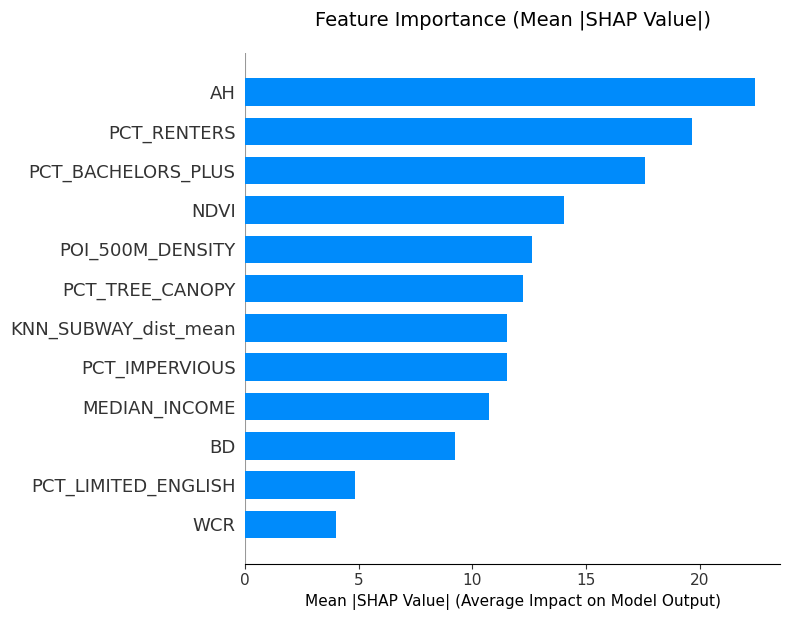

In [26]:
# Create a SHAP summary plot (bar chart) showing mean absolute SHAP values.
# This visualization ranks features by their average impact on model predictions.

if best_model_data:
    print(f"\n{'='*80}")
    print("SHAP SUMMARY PLOT: FEATURE IMPORTANCE (BAR CHART)")
    print(f"{'='*80}\n")
    
    print("This bar chart shows the mean absolute SHAP value for each feature.")
    print("Features are ranked from most to least important.")
    print("Higher bars indicate features with greater overall impact on predictions.\n")
    
    # Create the bar plot.
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_best, plot_type="bar", show=False)
    plt.title("Feature Importance (Mean |SHAP Value|)", fontsize=14, pad=20)
    plt.xlabel("Mean |SHAP Value| (Average Impact on Model Output)", fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo SHAP values available for visualization.")

### 8.3 SHAP Visualization: Beeswarm Plot


SHAP SUMMARY PLOT: BEESWARM (FEATURE IMPACT AND DIRECTION)

This beeswarm plot shows the distribution of SHAP values for each feature.
Each dot represents an observation, colored by the feature value:
  - Red (high feature value) -> Check if SHAP values are positive or negative.
  - Blue (low feature value) -> Check if SHAP values are positive or negative.
  - Horizontal position shows the magnitude and direction of impact.
  - Positive SHAP: increases predicted QOL call rate.
  - Negative SHAP: decreases predicted QOL call rate.



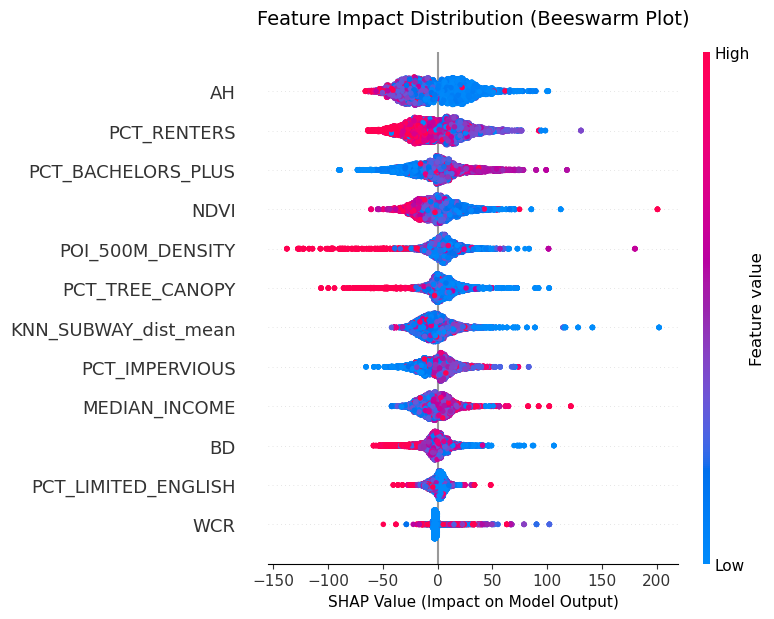

In [27]:
# Create a SHAP beeswarm plot showing the distribution and direction of feature impacts.
# This visualization shows how feature values relate to their impact on predictions.

if best_model_data:
    print(f"\n{'='*80}")
    print("SHAP SUMMARY PLOT: BEESWARM (FEATURE IMPACT AND DIRECTION)")
    print(f"{'='*80}\n")
    
    print("This beeswarm plot shows the distribution of SHAP values for each feature.")
    print("Each dot represents an observation, colored by the feature value:")
    print("  - Red (high feature value) -> Check if SHAP values are positive or negative.")
    print("  - Blue (low feature value) -> Check if SHAP values are positive or negative.")
    print("  - Horizontal position shows the magnitude and direction of impact.")
    print("  - Positive SHAP: increases predicted QOL call rate.")
    print("  - Negative SHAP: decreases predicted QOL call rate.\n")
    
    # Create the beeswarm plot.
    plt.figure(figsize=(10, 10))
    shap.summary_plot(shap_values, X_best, show=False)
    plt.title("Feature Impact Distribution (Beeswarm Plot)", fontsize=14, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo SHAP values available for visualization.")

## 9. Detailed Statistical Output Using statsmodels

In [28]:
# Fit the final OLS model using statsmodels for comprehensive statistical output.
# statsmodels provides detailed regression diagnostics including:
# - Coefficient estimates with standard errors and confidence intervals.
# - Statistical tests (t-statistics, p-values).
# - Model fit statistics (R-squared, adjusted R-squared, AIC, BIC).
# - Diagnostic tests (Durbin-Watson, Jarque-Bera, Omnibus).

if best_model_data:
    print(f"\n{'='*80}")
    print("FINAL OLS REGRESSION SUMMARY (STATSMODELS)")
    print(f"{'='*80}\n")
    
    # Set display options for better readability of numerical output.
    np.set_printoptions(precision=5, suppress=True)
    pd.set_option("display.float_format", lambda x: "%.5f" % x)
    
    # Prepare the feature matrix with constant term for statsmodels.
    X_final = best_model_data["df"][best_model_data["predictors"]].astype(float)
    X_final = sm.add_constant(X_final)  # Add intercept term.
    
    # Prepare the target vector.
    y_final = best_model_data["df"][y_col].astype(float)
    
    print(f"Fitting OLS model with statsmodels...")
    print(f"Regime: {best_model_data['regime']}")
    print(f"Predictor Set: {best_model_data['set_name']}")
    print(f"Number of Observations: {len(y_final)}")
    print(f"Number of Predictors: {len(best_model_data['predictors'])}\n")
    
    # Fit the OLS model using statsmodels.
    # The 'missing="drop"' parameter handles any remaining missing values.
    best_ols_model = sm.OLS(y_final, X_final, missing="drop").fit()
    
    # Print the comprehensive regression summary.
    print("\n" + "="*80)
    print("DETAILED REGRESSION OUTPUT")
    print("="*80 + "\n")
    print(best_ols_model.summary())
    
    # Additional interpretation notes.
    print("\n" + "="*80)
    print("INTERPRETATION NOTES")
    print("="*80)
    print("\nKey Statistics:")
    print(f"  - R-squared: Proportion of variance explained by the model.")
    print(f"  - Adjusted R-squared: R-squared adjusted for number of predictors.")
    print(f"  - F-statistic: Tests overall significance of the model.")
    print(f"  - AIC/BIC: Information criteria for model comparison (lower is better).")
    print(f"\nCoefficient Interpretation:")
    print(f"  - coef: Change in {y_col} for one-unit increase in predictor.")
    print(f"  - P>|t|: Statistical significance (< 0.05 typically significant).")
    print(f"  - [0.025, 0.975]: 95% confidence interval for the coefficient.")
    print(f"\nDiagnostic Tests:")
    print(f"  - Durbin-Watson: Tests for autocorrelation (values near 2 are ideal).")
    print(f"  - Jarque-Bera: Tests for normality of residuals.")
    print(f"  - Condition Number: High values (>30) may indicate multicollinearity.")
else:
    print("\nNo best model available for detailed statistical output.")


FINAL OLS REGRESSION SUMMARY (STATSMODELS)

Fitting OLS model with statsmodels...
Regime: Extreme Week 2
Predictor Set: All Features
Number of Observations: 9699
Number of Predictors: 12


DETAILED REGRESSION OUTPUT

                            OLS Regression Results                            
Dep. Variable:            QOL_RATE_1K   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     57.49
Date:                Mon, 24 Nov 2025   Prob (F-statistic):          5.84e-135
Time:                        03:05:50   Log-Likelihood:                -63218.
No. Observations:                9699   AIC:                         1.265e+05
Df Residuals:                    9686   BIC:                         1.266e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                  

### 9.1 XGBoost Model Summary

In [29]:
# Provide a summary of the XGBoost model performance for comparison with OLS.

if best_model_data:
    print(f"\n{'='*80}")
    print("XGBOOST MODEL FINAL SUMMARY")
    print(f"{'='*80}\n")
    
    print("Model Comparison:")
    print(f"  OLS CV R-squared:     {best_model_data['mean_r2']:.4f} ± {best_model_data['std_r2']:.4f}")
    print(f"  XGBoost CV R-squared: {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")
    print(f"\n  Performance Gain: {(xgb_scores.mean() - best_model_data['mean_r2']):.4f}")
    
    # Calculate feature importance from XGBoost.
    feature_importance = pd.DataFrame({
        "Feature": best_model_data["predictors"],
        "Importance": xgb_reg.feature_importances_
    }).sort_values("Importance", ascending=False)
    
    print("\nXGBoost Feature Importance (Gain-based):")
    print(feature_importance.to_string(index=False))
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
else:
    print("\nNo XGBoost model available for summary.")


XGBOOST MODEL FINAL SUMMARY

Model Comparison:
  OLS CV R-squared:     0.0588 ± 0.0229
  XGBoost CV R-squared: 0.0764 ± 0.0313

  Performance Gain: 0.0176

XGBoost Feature Importance (Gain-based):
             Feature  Importance
                  AH     0.12350
         PCT_RENTERS     0.10491
                NDVI     0.10250
    POI_500M_DENSITY     0.09661
KNN_SUBWAY_dist_mean     0.09207
  PCT_BACHELORS_PLUS     0.08547
                 WCR     0.08289
       MEDIAN_INCOME     0.07254
                  BD     0.06970
 PCT_LIMITED_ENGLISH     0.05831
     PCT_TREE_CANOPY     0.05599
      PCT_IMPERVIOUS     0.05550

ANALYSIS COMPLETE


## 10. Choropleth Map Visualizations

### 10.1 Prepare Data for Mapping

In this section, we create choropleth maps to visualize the spatial distribution of QOL call rates across different time periods:
- Extreme Week 1 (first extreme heat period).
- Extreme Week 2 (second extreme heat period).
- Normal Week 1 (non-extreme baseline period 1).
- Normal Week 2 (non-extreme baseline period 2).

We also calculate and map the difference between extreme and normal weeks to highlight heat-related impacts.

In [30]:
# Prepare aggregated data for mapping by calculating mean QOL rates for each tract.
# We need to aggregate the panel data to get representative values for each time period.

print(f"\n{'='*80}")
print("PREPARING DATA FOR CHOROPLETH MAPPING")
print(f"{'='*80}\n")

# Calculate mean QOL rate for each tract during Extreme Week 1.
# This represents the average QOL call rate during the first extreme heat period.
extreme_week_1_data = panel[panel["EXTREME_WEEK_1"] == 1].groupby("GEOID")[y_col].mean().reset_index()
extreme_week_1_data.columns = ["GEOID", "QOL_EXTREME_1"]
print(f"Extreme Week 1: {len(extreme_week_1_data)} tracts with data.")

# Calculate mean QOL rate for each tract during Extreme Week 2.
# This represents the average QOL call rate during the second extreme heat period.
extreme_week_2_data = panel[panel["EXTREME_WEEK_2"] == 1].groupby("GEOID")[y_col].mean().reset_index()
extreme_week_2_data.columns = ["GEOID", "QOL_EXTREME_2"]
print(f"Extreme Week 2: {len(extreme_week_2_data)} tracts with data.")

# Calculate mean QOL rate for each tract during non-extreme weeks.
# We'll split the normal weeks into two groups for comparison with the two extreme weeks.
normal_weeks_data = panel[(panel["EXTREME_WEEK_1"] == 0) & (panel["EXTREME_WEEK_2"] == 0)].copy()

# Get unique weeks in the normal period and split them into two groups.
normal_weeks = sorted(normal_weeks_data["WEEK"].unique())
midpoint = len(normal_weeks) // 2
normal_weeks_1 = normal_weeks[:midpoint]
normal_weeks_2 = normal_weeks[midpoint:]

print(f"\nNormal weeks identified: {len(normal_weeks)} total weeks.")
print(f"  - Normal Week 1 group: weeks {min(normal_weeks_1)} to {max(normal_weeks_1)}.")
print(f"  - Normal Week 2 group: weeks {min(normal_weeks_2)} to {max(normal_weeks_2)}.")

# Calculate mean QOL rate for Normal Week 1 group.
normal_week_1_data = normal_weeks_data[normal_weeks_data["WEEK"].isin(normal_weeks_1)].groupby("GEOID")[y_col].mean().reset_index()
normal_week_1_data.columns = ["GEOID", "QOL_NORMAL_1"]
print(f"\nNormal Week 1 group: {len(normal_week_1_data)} tracts with data.")

# Calculate mean QOL rate for Normal Week 2 group.
normal_week_2_data = normal_weeks_data[normal_weeks_data["WEEK"].isin(normal_weeks_2)].groupby("GEOID")[y_col].mean().reset_index()
normal_week_2_data.columns = ["GEOID", "QOL_NORMAL_2"]
print(f"Normal Week 2 group: {len(normal_week_2_data)} tracts with data.")


PREPARING DATA FOR CHOROPLETH MAPPING

Extreme Week 1: 2311 tracts with data.
Extreme Week 2: 2276 tracts with data.

Normal weeks identified: 13 total weeks.
  - Normal Week 1 group: weeks 22 to 27.
  - Normal Week 2 group: weeks 28 to 34.

Normal Week 1 group: 2313 tracts with data.
Normal Week 2 group: 2316 tracts with data.


In [31]:
# Merge all the aggregated data with the tract geometries for mapping.
# Start with a fresh copy of the tracts GeoDataFrame.

print("\nMerging aggregated data with tract geometries...")

# Create a mapping GeoDataFrame starting with the tract geometries.
tracts_map = tracts[["geoid", "geometry"]].copy()
tracts_map = tracts_map.rename(columns={"geoid": "GEOID"})

# Merge each time period's data.
tracts_map = tracts_map.merge(extreme_week_1_data, on="GEOID", how="left")
tracts_map = tracts_map.merge(extreme_week_2_data, on="GEOID", how="left")
tracts_map = tracts_map.merge(normal_week_1_data, on="GEOID", how="left")
tracts_map = tracts_map.merge(normal_week_2_data, on="GEOID", how="left")

# Calculate the difference between extreme and normal weeks.
# Positive values indicate higher QOL call rates during extreme heat.
tracts_map["DIFF_1"] = tracts_map["QOL_EXTREME_1"] - tracts_map["QOL_NORMAL_1"]
tracts_map["DIFF_2"] = tracts_map["QOL_EXTREME_2"] - tracts_map["QOL_NORMAL_2"]

print(f"\nMapping data prepared. Total tracts: {len(tracts_map)}.")
print(f"\nSummary of missing values:")
print(tracts_map[["QOL_EXTREME_1", "QOL_EXTREME_2", "QOL_NORMAL_1", "QOL_NORMAL_2", "DIFF_1", "DIFF_2"]].isnull().sum())


Merging aggregated data with tract geometries...

Mapping data prepared. Total tracts: 2325.

Summary of missing values:
QOL_EXTREME_1    14
QOL_EXTREME_2    49
QOL_NORMAL_1     12
QOL_NORMAL_2      9
DIFF_1           22
DIFF_2           49
dtype: int64


### 10.2 Choropleth Maps: Extreme vs Normal Weeks


CREATING CHOROPLETH MAPS: EXTREME VS NORMAL WEEKS

Color scale range: 0.00 to 1000.00


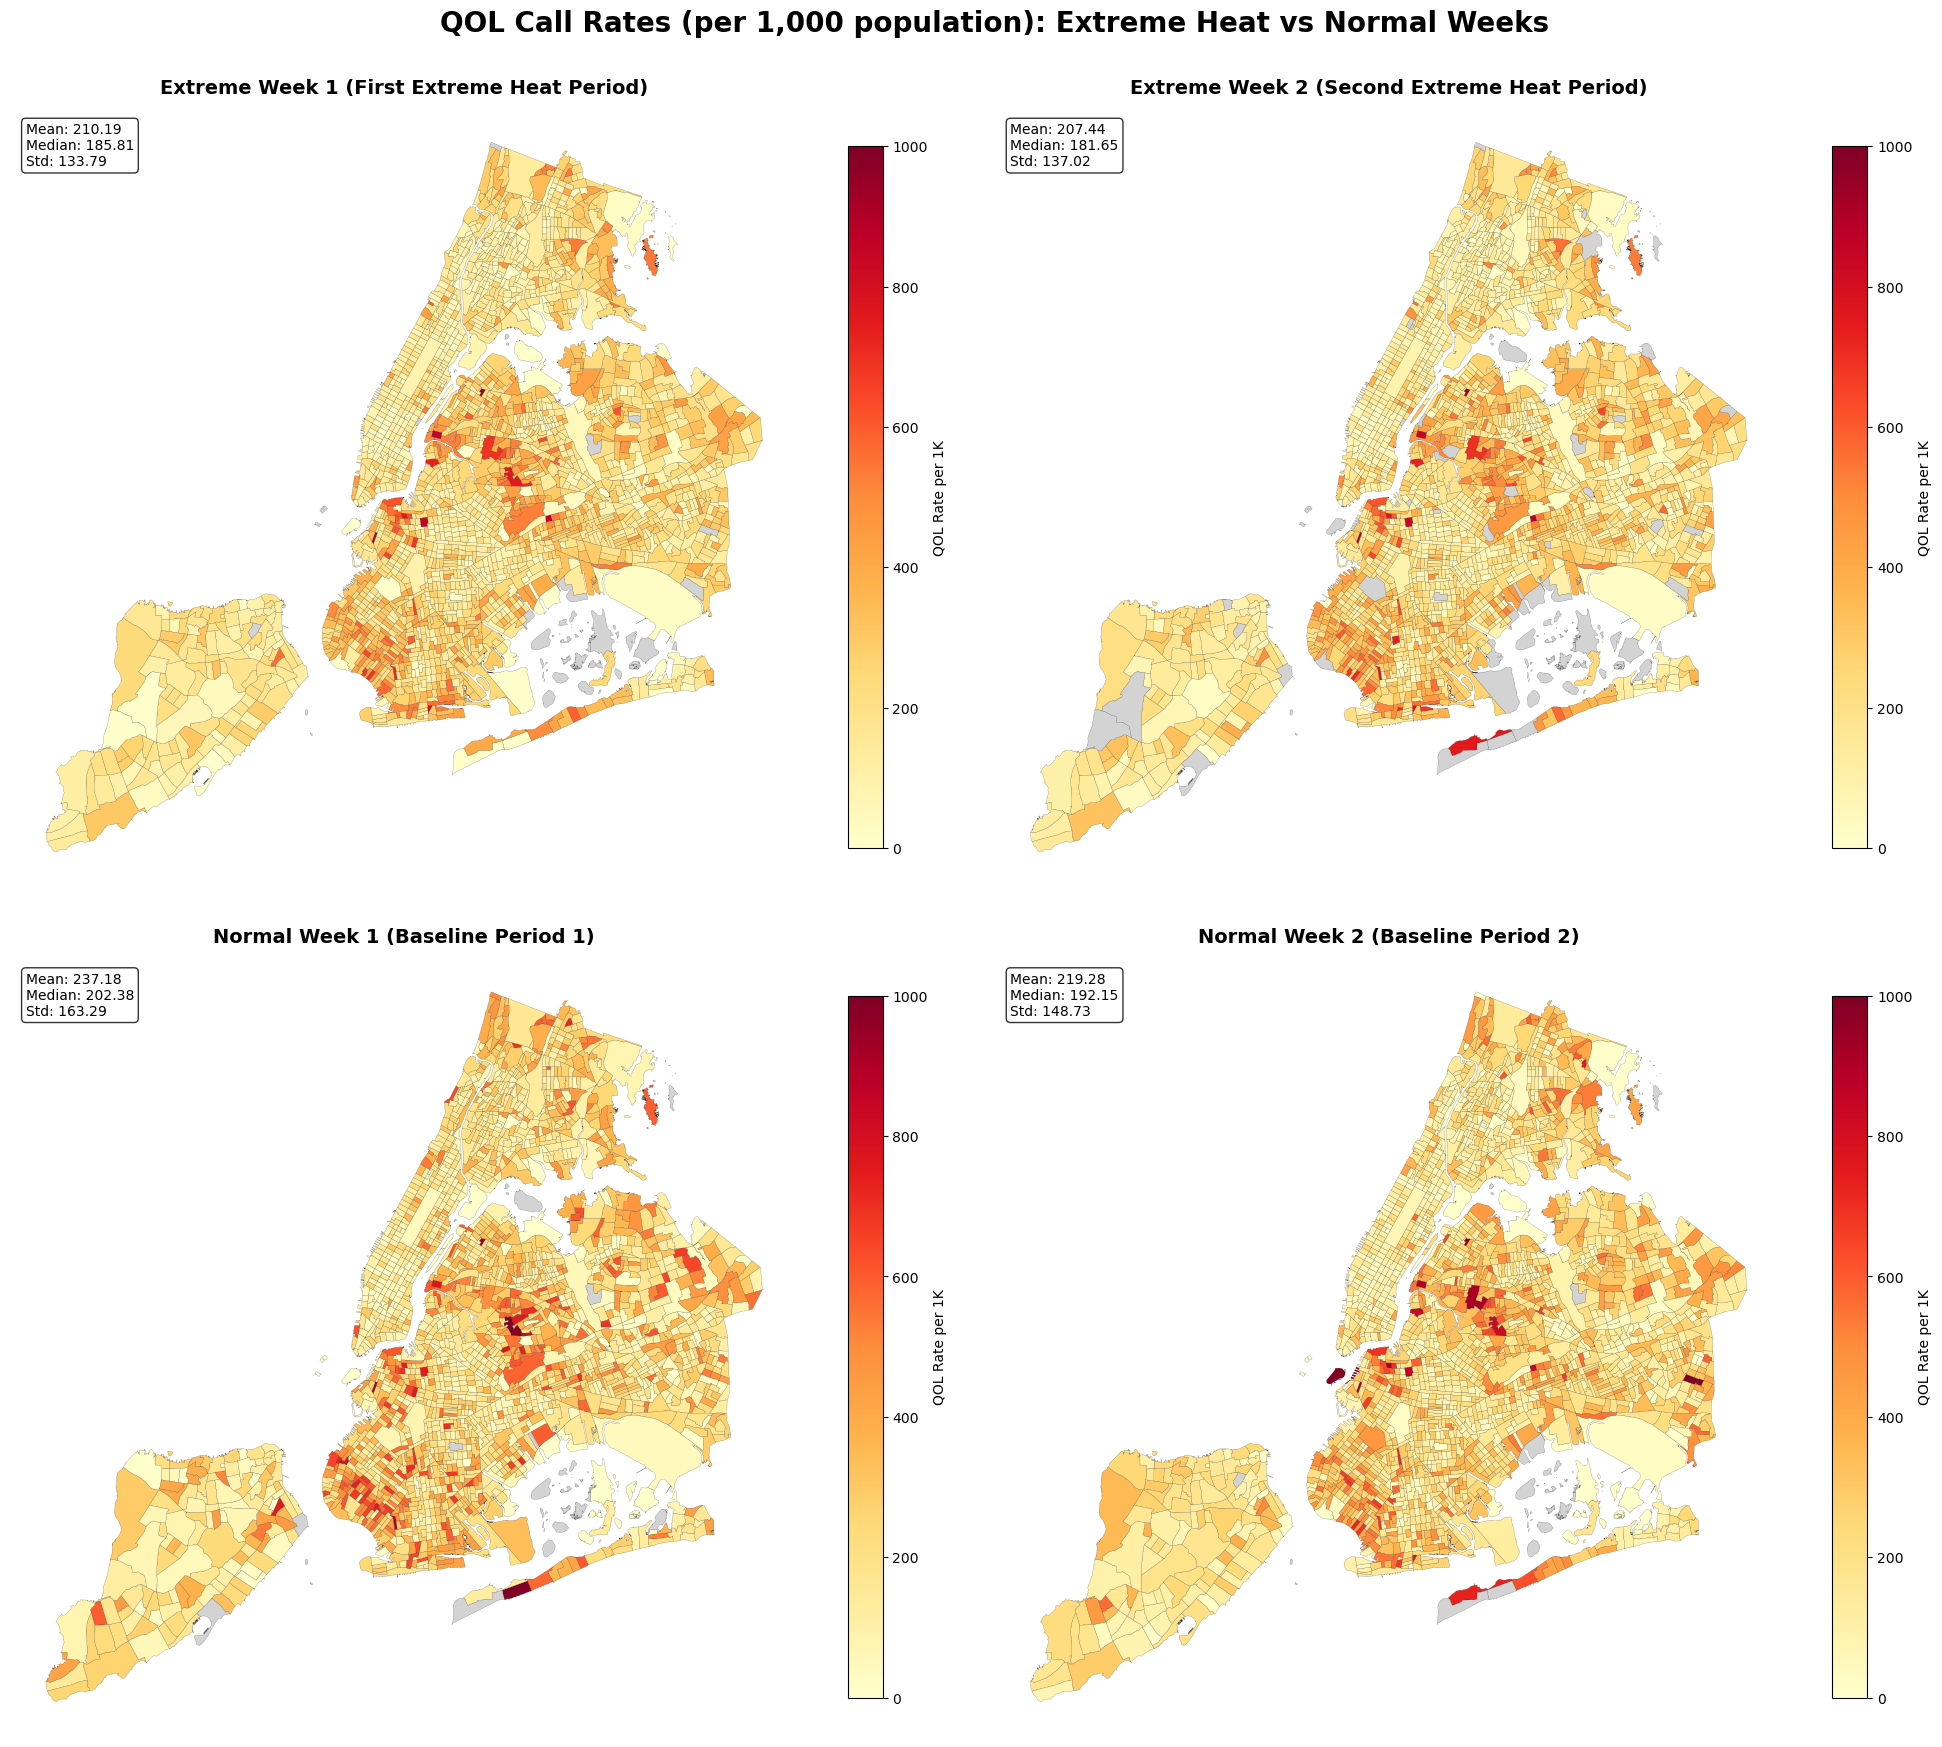


Four-panel choropleth map created successfully.


In [32]:
# Create a 2x2 grid of choropleth maps showing QOL rates for each time period.
# This visualization allows for direct visual comparison across all four periods.

print(f"\n{'='*80}")
print("CREATING CHOROPLETH MAPS: EXTREME VS NORMAL WEEKS")
print(f"{'='*80}\n")

# Create figure with 2x2 subplot grid.
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
fig.suptitle("QOL Call Rates (per 1,000 population): Extreme Heat vs Normal Weeks", 
             fontsize=20, fontweight="bold", y=0.995)

# Define a consistent color scale across all maps for comparability.
# Use the overall min and max values to set the color range.
vmin = tracts_map[["QOL_EXTREME_1", "QOL_EXTREME_2", "QOL_NORMAL_1", "QOL_NORMAL_2"]].min().min()
vmax = tracts_map[["QOL_EXTREME_1", "QOL_EXTREME_2", "QOL_NORMAL_1", "QOL_NORMAL_2"]].max().max()

print(f"Color scale range: {vmin:.2f} to {vmax:.2f}")

# Plot 1: Extreme Week 1.
ax1 = axes[0, 0]
tracts_map.plot(
    column="QOL_EXTREME_1",
    ax=ax1,
    legend=True,
    cmap="YlOrRd",
    edgecolor="black",
    linewidth=0.1,
    vmin=vmin,
    vmax=vmax,
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    legend_kwds={"label": "QOL Rate per 1K", "shrink": 0.8}
)
ax1.set_title("Extreme Week 1 (First Extreme Heat Period)", fontsize=14, fontweight="bold", pad=10)
ax1.axis("off")

# Add statistics as text on the map.
stats_1 = f"Mean: {tracts_map['QOL_EXTREME_1'].mean():.2f}\nMedian: {tracts_map['QOL_EXTREME_1'].median():.2f}\nStd: {tracts_map['QOL_EXTREME_1'].std():.2f}"
ax1.text(0.02, 0.98, stats_1, transform=ax1.transAxes, 
         fontsize=10, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Plot 2: Extreme Week 2.
ax2 = axes[0, 1]
tracts_map.plot(
    column="QOL_EXTREME_2",
    ax=ax2,
    legend=True,
    cmap="YlOrRd",
    edgecolor="black",
    linewidth=0.1,
    vmin=vmin,
    vmax=vmax,
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    legend_kwds={"label": "QOL Rate per 1K", "shrink": 0.8}
)
ax2.set_title("Extreme Week 2 (Second Extreme Heat Period)", fontsize=14, fontweight="bold", pad=10)
ax2.axis("off")

# Add statistics.
stats_2 = f"Mean: {tracts_map['QOL_EXTREME_2'].mean():.2f}\nMedian: {tracts_map['QOL_EXTREME_2'].median():.2f}\nStd: {tracts_map['QOL_EXTREME_2'].std():.2f}"
ax2.text(0.02, 0.98, stats_2, transform=ax2.transAxes, 
         fontsize=10, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Plot 3: Normal Week 1.
ax3 = axes[1, 0]
tracts_map.plot(
    column="QOL_NORMAL_1",
    ax=ax3,
    legend=True,
    cmap="YlOrRd",
    edgecolor="black",
    linewidth=0.1,
    vmin=vmin,
    vmax=vmax,
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    legend_kwds={"label": "QOL Rate per 1K", "shrink": 0.8}
)
ax3.set_title("Normal Week 1 (Baseline Period 1)", fontsize=14, fontweight="bold", pad=10)
ax3.axis("off")

# Add statistics.
stats_3 = f"Mean: {tracts_map['QOL_NORMAL_1'].mean():.2f}\nMedian: {tracts_map['QOL_NORMAL_1'].median():.2f}\nStd: {tracts_map['QOL_NORMAL_1'].std():.2f}"
ax3.text(0.02, 0.98, stats_3, transform=ax3.transAxes, 
         fontsize=10, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Plot 4: Normal Week 2.
ax4 = axes[1, 1]
tracts_map.plot(
    column="QOL_NORMAL_2",
    ax=ax4,
    legend=True,
    cmap="YlOrRd",
    edgecolor="black",
    linewidth=0.1,
    vmin=vmin,
    vmax=vmax,
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    legend_kwds={"label": "QOL Rate per 1K", "shrink": 0.8}
)
ax4.set_title("Normal Week 2 (Baseline Period 2)", fontsize=14, fontweight="bold", pad=10)
ax4.axis("off")

# Add statistics.
stats_4 = f"Mean: {tracts_map['QOL_NORMAL_2'].mean():.2f}\nMedian: {tracts_map['QOL_NORMAL_2'].median():.2f}\nStd: {tracts_map['QOL_NORMAL_2'].std():.2f}"
ax4.text(0.02, 0.98, stats_4, transform=ax4.transAxes, 
         fontsize=10, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Adjust layout and display.
plt.tight_layout()
plt.show()

print("\nFour-panel choropleth map created successfully.")

### 10.3 Choropleth Maps: Difference Between Extreme and Normal Weeks


CREATING DIFFERENCE MAPS: EXTREME HEAT IMPACT

Difference color scale range: -1000.00 to 1000.00


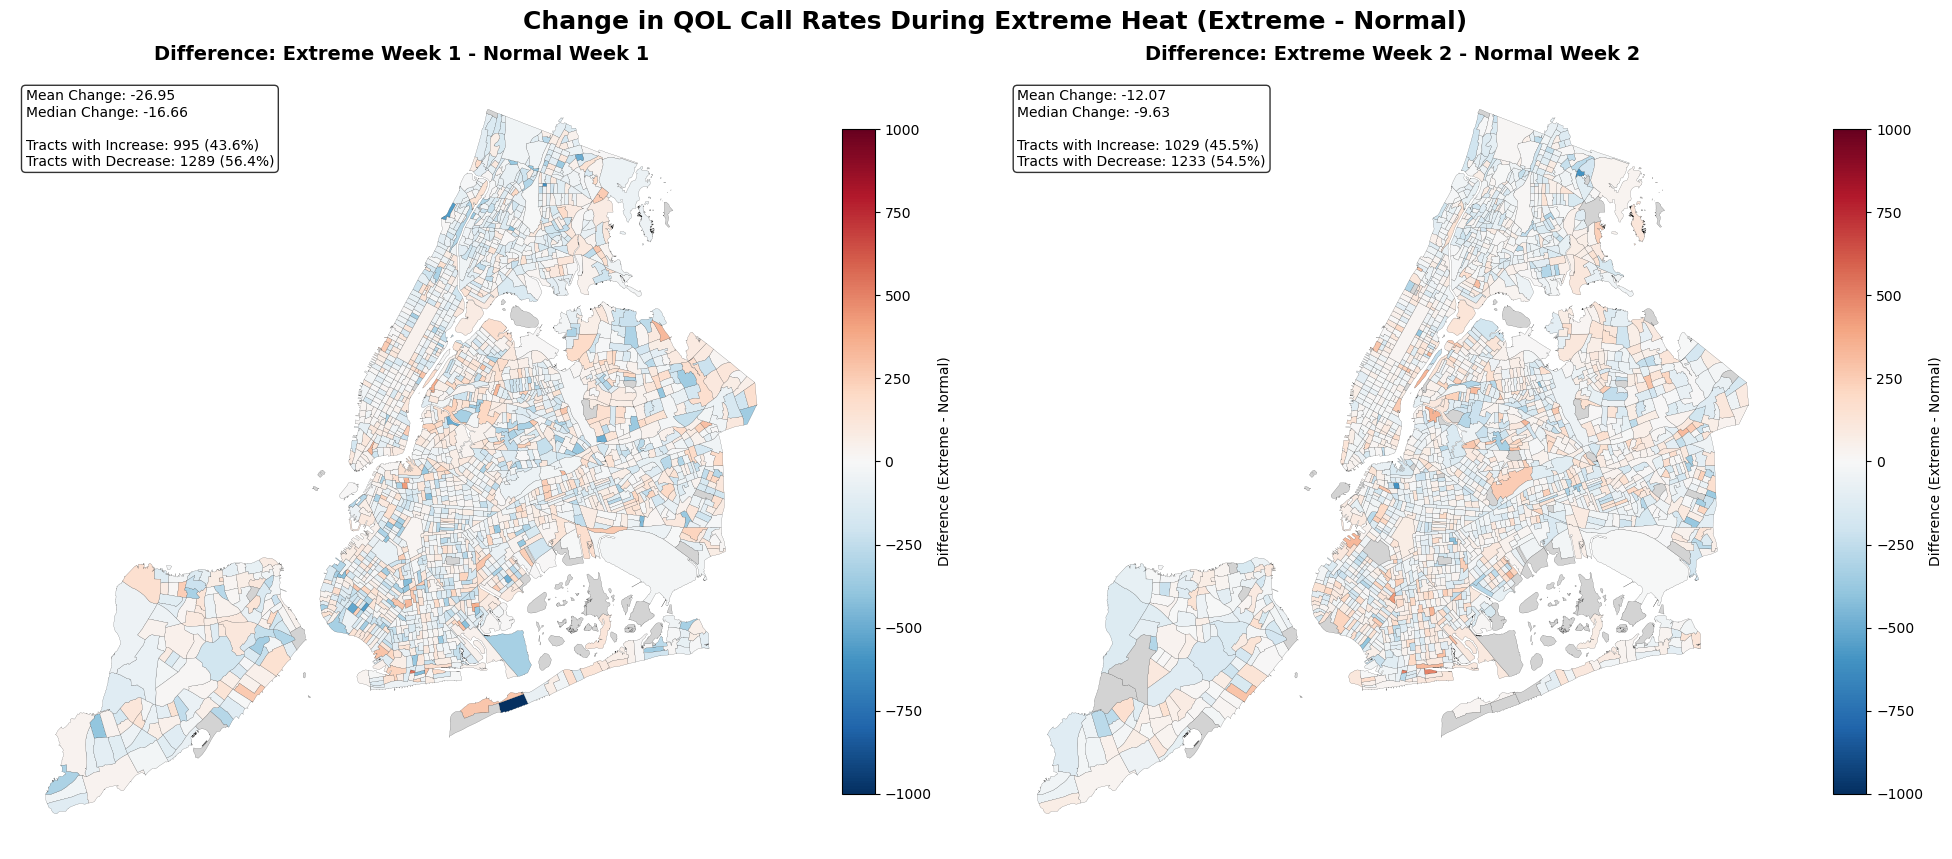


Difference maps created successfully.

Interpretation:
  Red areas: QOL call rates increased during extreme heat.
  Blue areas: QOL call rates decreased during extreme heat.
  White/light areas: Little to no change in QOL call rates.


In [33]:
# Create difference maps showing the change in QOL rates during extreme heat.
# Positive values (red) indicate areas where QOL calls increased during extreme heat.
# Negative values (blue) indicate areas where QOL calls decreased during extreme heat.

print(f"\n{'='*80}")
print("CREATING DIFFERENCE MAPS: EXTREME HEAT IMPACT")
print(f"{'='*80}\n")

# Create figure with 1x2 subplot grid for the two difference maps.
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle("Change in QOL Call Rates During Extreme Heat (Extreme - Normal)", 
             fontsize=18, fontweight="bold", y=0.98)

# Define a symmetric color scale centered at zero.
# This makes it easy to see increases (red) vs decreases (blue).
diff_max = max(abs(tracts_map["DIFF_1"].min()), abs(tracts_map["DIFF_1"].max()),
               abs(tracts_map["DIFF_2"].min()), abs(tracts_map["DIFF_2"].max()))
diff_vmin = -diff_max
diff_vmax = diff_max

print(f"Difference color scale range: {diff_vmin:.2f} to {diff_vmax:.2f}")

# Plot 1: Difference between Extreme Week 1 and Normal Week 1.
ax1 = axes[0]
tracts_map.plot(
    column="DIFF_1",
    ax=ax1,
    legend=True,
    cmap="RdBu_r",  # Red for positive (increase), Blue for negative (decrease).
    edgecolor="black",
    linewidth=0.1,
    vmin=diff_vmin,
    vmax=diff_vmax,
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    legend_kwds={"label": "Difference (Extreme - Normal)", "shrink": 0.8}
)
ax1.set_title("Difference: Extreme Week 1 - Normal Week 1", fontsize=14, fontweight="bold", pad=10)
ax1.axis("off")

# Add statistics and interpretation.
diff_1_mean = tracts_map["DIFF_1"].mean()
diff_1_median = tracts_map["DIFF_1"].median()
diff_1_positive = (tracts_map["DIFF_1"] > 0).sum()
diff_1_negative = (tracts_map["DIFF_1"] < 0).sum()
diff_1_total = diff_1_positive + diff_1_negative
pct_positive_1 = (diff_1_positive / diff_1_total * 100) if diff_1_total > 0 else 0

stats_diff_1 = f"Mean Change: {diff_1_mean:.2f}\nMedian Change: {diff_1_median:.2f}\n\nTracts with Increase: {diff_1_positive} ({pct_positive_1:.1f}%)\nTracts with Decrease: {diff_1_negative} ({100-pct_positive_1:.1f}%)"
ax1.text(0.02, 0.98, stats_diff_1, transform=ax1.transAxes, 
         fontsize=10, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Plot 2: Difference between Extreme Week 2 and Normal Week 2.
ax2 = axes[1]
tracts_map.plot(
    column="DIFF_2",
    ax=ax2,
    legend=True,
    cmap="RdBu_r",
    edgecolor="black",
    linewidth=0.1,
    vmin=diff_vmin,
    vmax=diff_vmax,
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    legend_kwds={"label": "Difference (Extreme - Normal)", "shrink": 0.8}
)
ax2.set_title("Difference: Extreme Week 2 - Normal Week 2", fontsize=14, fontweight="bold", pad=10)
ax2.axis("off")

# Add statistics and interpretation.
diff_2_mean = tracts_map["DIFF_2"].mean()
diff_2_median = tracts_map["DIFF_2"].median()
diff_2_positive = (tracts_map["DIFF_2"] > 0).sum()
diff_2_negative = (tracts_map["DIFF_2"] < 0).sum()
diff_2_total = diff_2_positive + diff_2_negative
pct_positive_2 = (diff_2_positive / diff_2_total * 100) if diff_2_total > 0 else 0

stats_diff_2 = f"Mean Change: {diff_2_mean:.2f}\nMedian Change: {diff_2_median:.2f}\n\nTracts with Increase: {diff_2_positive} ({pct_positive_2:.1f}%)\nTracts with Decrease: {diff_2_negative} ({100-pct_positive_2:.1f}%)"
ax2.text(0.02, 0.98, stats_diff_2, transform=ax2.transAxes, 
         fontsize=10, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Adjust layout and display.
plt.tight_layout()
plt.show()

print("\nDifference maps created successfully.")
print(f"\nInterpretation:")
print(f"  Red areas: QOL call rates increased during extreme heat.")
print(f"  Blue areas: QOL call rates decreased during extreme heat.")
print(f"  White/light areas: Little to no change in QOL call rates.")

### 10.4 Summary Statistics for Mapping Analysis

In [34]:
# Provide comprehensive summary statistics for all mapped variables.

print(f"\n{'='*80}")
print("SUMMARY STATISTICS FOR CHOROPLETH ANALYSIS")
print(f"{'='*80}\n")

# Create a summary table.
summary_data = []

for col, label in [("QOL_EXTREME_1", "Extreme Week 1"),
                   ("QOL_EXTREME_2", "Extreme Week 2"),
                   ("QOL_NORMAL_1", "Normal Week 1"),
                   ("QOL_NORMAL_2", "Normal Week 2"),
                   ("DIFF_1", "Difference 1 (Ext1 - Norm1)"),
                   ("DIFF_2", "Difference 2 (Ext2 - Norm2)")]:
    
    summary_data.append({
        "Variable": label,
        "Mean": tracts_map[col].mean(),
        "Median": tracts_map[col].median(),
        "Std Dev": tracts_map[col].std(),
        "Min": tracts_map[col].min(),
        "Max": tracts_map[col].max(),
        "Valid Tracts": tracts_map[col].notna().sum()
    })

summary_df = pd.DataFrame(summary_data)
print("Descriptive Statistics:")
print(summary_df.to_string(index=False))

# Test for statistical significance of differences.
print(f"\n\n{'='*80}")
print("STATISTICAL SIGNIFICANCE TESTING")
print(f"{'='*80}\n")

from scipy import stats

# Paired t-test for Extreme Week 1 vs Normal Week 1.
# Remove NaN values for valid comparison.
valid_diff_1 = tracts_map[["QOL_EXTREME_1", "QOL_NORMAL_1"]].dropna()
if len(valid_diff_1) > 0:
    t_stat_1, p_value_1 = stats.ttest_rel(valid_diff_1["QOL_EXTREME_1"], valid_diff_1["QOL_NORMAL_1"])
    print(f"Paired t-test: Extreme Week 1 vs Normal Week 1")
    print(f"  t-statistic: {t_stat_1:.4f}")
    print(f"  p-value: {p_value_1:.4e}")
    print(f"  Significant at α=0.05: {'Yes' if p_value_1 < 0.05 else 'No'}")
    print(f"  Sample size: {len(valid_diff_1)} tracts\n")

# Paired t-test for Extreme Week 2 vs Normal Week 2.
valid_diff_2 = tracts_map[["QOL_EXTREME_2", "QOL_NORMAL_2"]].dropna()
if len(valid_diff_2) > 0:
    t_stat_2, p_value_2 = stats.ttest_rel(valid_diff_2["QOL_EXTREME_2"], valid_diff_2["QOL_NORMAL_2"])
    print(f"Paired t-test: Extreme Week 2 vs Normal Week 2")
    print(f"  t-statistic: {t_stat_2:.4f}")
    print(f"  p-value: {p_value_2:.4e}")
    print(f"  Significant at α=0.05: {'Yes' if p_value_2 < 0.05 else 'No'}")
    print(f"  Sample size: {len(valid_diff_2)} tracts\n")

print(f"\n{'='*80}")
print("CHOROPLETH MAPPING ANALYSIS COMPLETE")
print(f"{'='*80}")


SUMMARY STATISTICS FOR CHOROPLETH ANALYSIS

Descriptive Statistics:
                   Variable      Mean    Median   Std Dev         Min        Max  Valid Tracts
             Extreme Week 1 210.18538 185.81283 133.78675     0.00000  932.22393          2311
             Extreme Week 2 207.43725 181.64522 137.02173     0.00000  933.98352          2276
              Normal Week 1 237.17596 202.38095 163.28558     0.00000 1000.00000          2313
              Normal Week 2 219.28332 192.14928 148.72631     0.00000 1000.00000          2316
Difference 1 (Ext1 - Norm1) -26.94957 -16.65526 131.76876 -1000.00000  540.97222          2303
Difference 2 (Ext2 - Norm2) -12.06592  -9.62731 108.55643  -600.00000  506.94444          2276


STATISTICAL SIGNIFICANCE TESTING

Paired t-test: Extreme Week 1 vs Normal Week 1
  t-statistic: -9.8149
  p-value: 2.6426e-22
  Significant at α=0.05: Yes
  Sample size: 2303 tracts

Paired t-test: Extreme Week 2 vs Normal Week 2
  t-statistic: -5.3026
  p-value: 